In [179]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import seaborn as sb
import pandas as pd
import random as rd

from copy import deepcopy as copy
from collections import defaultdict
from collections import Counter
from MDAnalysis.analysis import pca as mda_pca
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix
from scipy import linalg
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

%matplotlib inline

import nglview as nv

import sys
import warnings
warnings.filterwarnings('ignore')

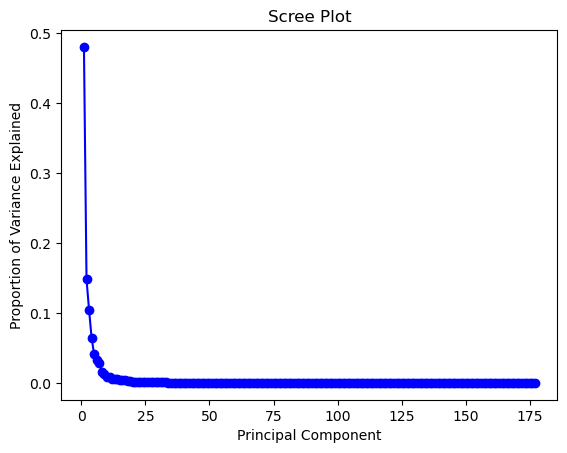

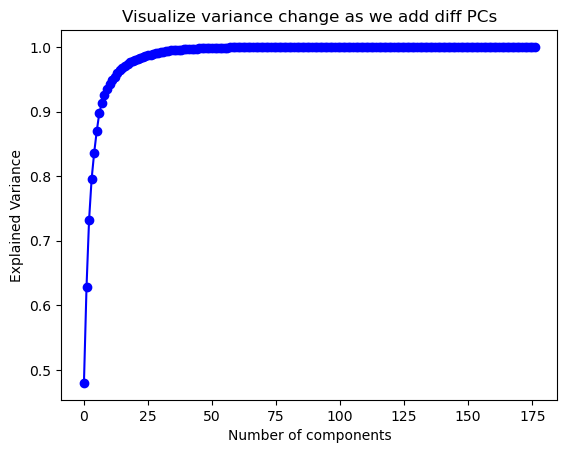

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


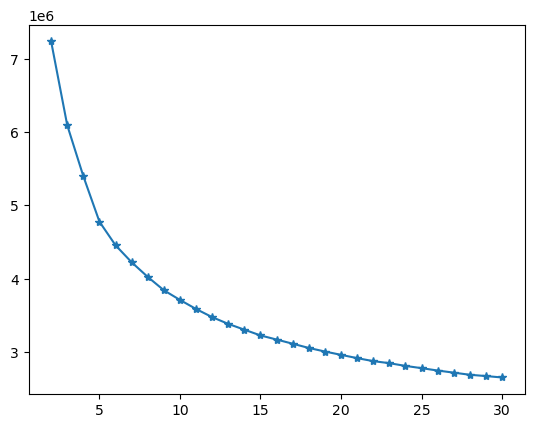

In [2]:
data = np.loadtxt('high_variance_distances.dat')
data_pts = data.copy()
data.shape

pca = PCA()
pca.fit(data)
new_data = pca.transform(data)

PC_values = np.arange(pca.n_components_) + 1

plt.title('Scree Plot')
plt.plot(PC_values, pca.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

plt.title('Visualize variance change as we add diff PCs')
plt.ylabel('Explained Variance')
plt.xlabel('Number of components')
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.show()

obj_list = []
kmin=2
kmax=31
for k in range(kmin,kmax):
    print(k)
    kmeans = KMeans(n_clusters=k).fit(data)
    obj_min = kmeans.inertia_
    obj_list.append(obj_min)

plt.plot(np.arange(kmin,kmax), obj_list, '*-')

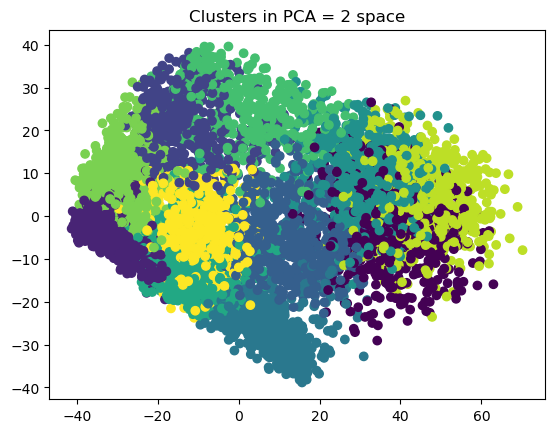

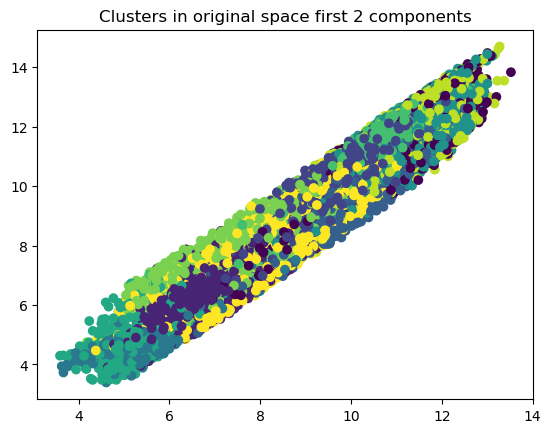

In [3]:
x = data
nc_pca = 2
pca_2 = PCA(n_components=nc_pca)
new_x = pca_2.fit_transform(x)
skm = KMeans(n_clusters=11).fit(x)
skz = skm.labels_
plt.title(f"Clusters in PCA = {nc_pca} space")
plt.scatter(new_x[:,0], new_x[:,1], c=skz)
plt.show()
plt.title("Clusters in original space first 2 components")
plt.scatter(x[:,0], x[:,1], c=skz)
plt.show()

In [218]:
class kmeans:

    def __init__(self, N_c):
        
        self.N_centroids = N_c
        
    def initialization_of_centroids_random(self):    
        sel = np.random.choice(self.N_points, size=self.N_centroids, replace=False)
        return self.data[ sel ]
    
    def initialization_of_centroids_plusplus(self):    
        i=rd.randint(0,self.N_points-1)
        centroids=np.array([self.data[i]])
        for k in range(1, self.N_centroids):
            D=np.array([]) 
            D=np.append(D,np.min(cdist(self.data, centroids,'sqeuclidean'), axis=1))
            prob=D/np.sum(D)
            cummulative_prob=np.cumsum(prob)
            r=rd.random()
            i=0
            for j,p in enumerate(cummulative_prob):
                if r<p:
                    i=j
                    break
            centroids=np.append(centroids,[self.data[i]],axis=0)
        return centroids
         
    
    def fit(self, data, init="random", N_max_iterations=1000):
        
        self.data=data
        self.N_points = np.shape(self.data)[0]
        
        if init=="k-means++":
            self.centroid_positions =  self.initialization_of_centroids_plusplus()
        else:    
            self.centroid_positions =  self.initialization_of_centroids_random()
            
        for cnt in range(N_max_iterations):
            dist2_mat = cdist(self.data, self.centroid_positions,'sqeuclidean')   
            dist2_min = np.array([np.min(dist2_mat, axis = 1) ]) 
            self.labels = np.argmin(dist2_mat, axis = 1)
            loss = dist2_min.sum() 
            skip=False
            for i in range(self.N_centroids):
                if len(self.data[self.labels  == i ]) == 0:
                    skip = True
            if skip == True :
                self.centroid_positions = self.initialization_of_centroids_random()
                continue
            new_centers = np.array([self.data[self.labels  == i].mean(axis=0) for i in range(self.N_centroids)])
            if np.all(self.centroid_positions == new_centers):
                break
            self.centroid_positions = new_centers
        if cnt == N_max_iterations-1: 
            print("Max iterations reached")
        return loss, cnt, new_centers

       
    def plot(self):    
        
        colors = plt.cm.get_cmap('rainbow')(np.linspace(0, 1, self.N_centroids))
        title_ = "label graph" 
        fig = plt.figure()
        label_set = set(self.labels)
        label_count = len(label_set)
        for cen in range(self.N_centroids):
            arr_points=self.data[self.labels  == cen]
            plt.scatter(arr_points[:,0],arr_points[:,1], color=colors[cen],s=4)
        plt.scatter(self.centroid_positions[:,0],self.centroid_positions[:,1], color="k")   
        title_text = 'No. of Points: %d, No. of Labels: %d' % (self.N_points, label_count)
        plt.title(title_text)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        
    def get_assignation(self):
        out = np.empty((self.N_points,3))
        for idx in range(self.N_points):
            out[idx,0]=self.data[idx][0]
            out[idx,1]=self.data[idx][1]
            out[idx,2]=self.labels[idx]
        return out

    def get_centroid_positions(self):
        return self.centroid_positions
     

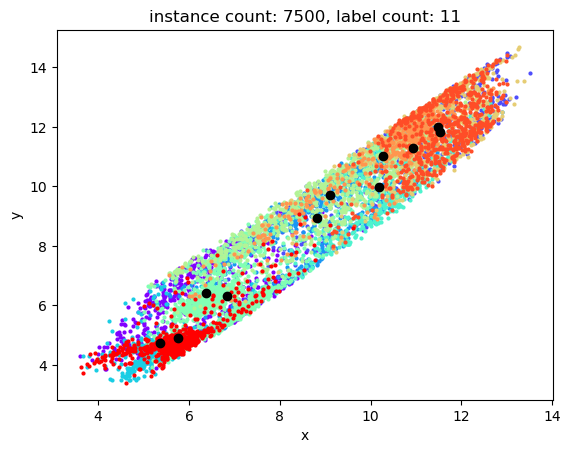

3625297.3471967047 44


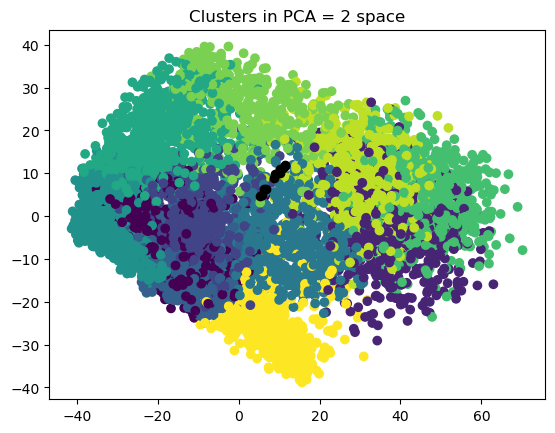

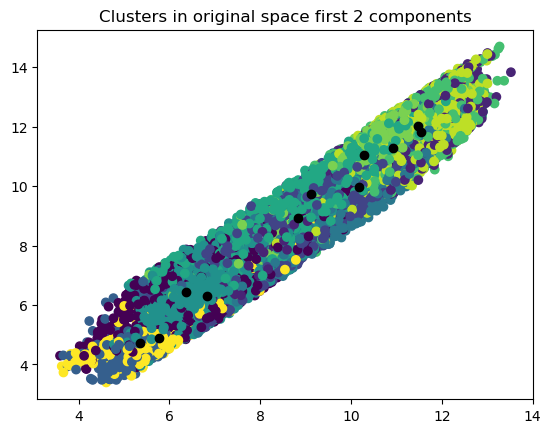

In [222]:
test_k = 11
test_km = kmeans(test_k)
loss,iteration,test_centroid_positions=test_km.fit(data)
test_km.plot()
print(loss,iteration)

test_labels = test_km.get_assignation()
#test_centroid_positions = test_km.get_centroid_positions()

plt.title(f"Clusters in PCA = {nc_pca} space")
plt.scatter(new_x[:,0], new_x[:,1], c=test_labels[:,2])
plt.scatter(test_centroid_positions[:,0], test_centroid_positions[:,1], color='k')
plt.show()

plt.title("Clusters in original space first 2 components")
plt.scatter(test_labels[:,0], test_labels[:,1], c=test_labels[:,2])
plt.scatter(test_centroid_positions[:,0], test_centroid_positions[:,1], color='k')
plt.show()

mean =  2812204.1769234394
i_min =  9
min =  2785233.471024037
avg convergence =  53.233333333333334


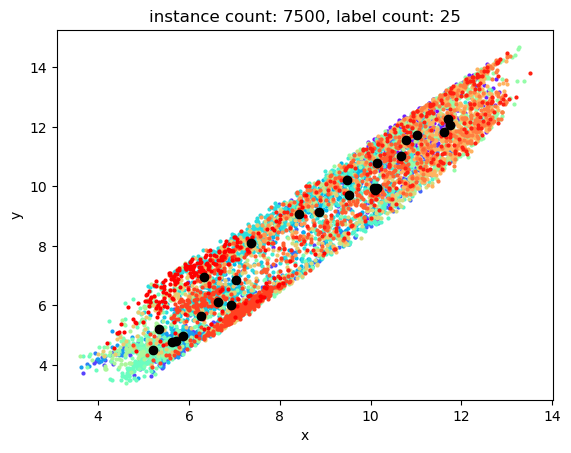

In [6]:
N_simulations=30
tmp_km = kmeans(25)
min_loss = np.inf
losses = np.empty(N_simulations)
i_tmp = 0
iterations = np.empty(N_simulations)
for i in range(N_simulations):
    loss,iteration,_=tmp_km.fit(data=data_pts, init="random") 
    if loss < min_loss:
        min_loss=loss
        i_min=i
        min_km = tmp_km
    #print(i, loss, iteration)    
    losses[i]=loss
    iterations[i]=iteration
    
min_km.plot()
print("mean = ",losses.mean())
print("i_min = ",i_min)
print("min = ",losses[i_min])    
print("avg convergence = ",iterations.mean())
plt.show()

mean =  2797769.4181434577
i_min =  16
min =  2771398.9010920483
avg convergence =  50.13333333333333


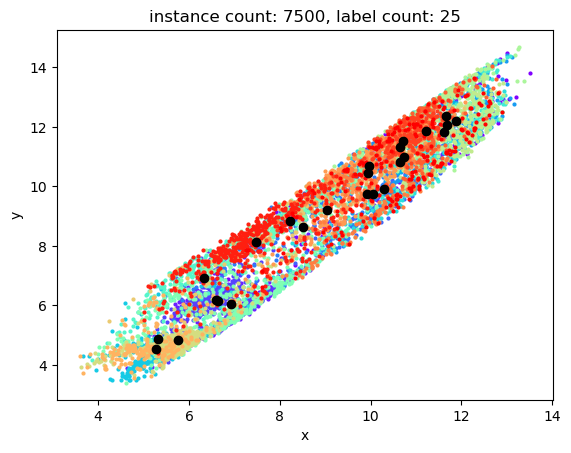

In [7]:
N_simulations=30
tmp_kmpp = kmeans(25)
min_loss= np.inf
losses = np.empty(N_simulations)
i_tmp = 0
iterations = np.empty(N_simulations)
for i in range(N_simulations):
    loss,iteration,_=tmp_kmpp.fit(data=data_pts, init="k-means++") 
    if loss<min_loss:
        min_loss=loss
        i_min=i
        min_kmpp = tmp_kmpp
    #print(i,loss,iteration)        
    losses[i]=loss
    iterations[i]=iteration
    
min_kmpp.plot()
print("mean = ",losses.mean())
print("i_min = ",i_min)
print("min = ",losses[i_min])    
print("avg convergence = ",iterations.mean())
plt.show()

2 7238885.206879026
3 6094788.565800704
4 5398169.5045343675
5 4777464.9832361415
6 4454980.44908721
7 4222996.097416623
8 4023209.9248162876
9 3841044.7175377486
10 3708826.1480751005
11 3591866.4363599094
12 3492168.000529648
13 3381466.287324991
14 3303153.8751430237
15 3224437.7928817477
16 3166785.9598991494
17 3117126.8042049548
18 3067922.9211234404
19 3004131.8599413326
20 2964178.3959214184
21 2921046.320479531
22 2884144.630779499
23 2844165.7733690413
24 2818493.724163792
25 2781694.8087780895
26 2749570.00829539
27 2718152.7525188704
28 2698820.036667292
29 2673908.1163367163
30 2639254.0537344553


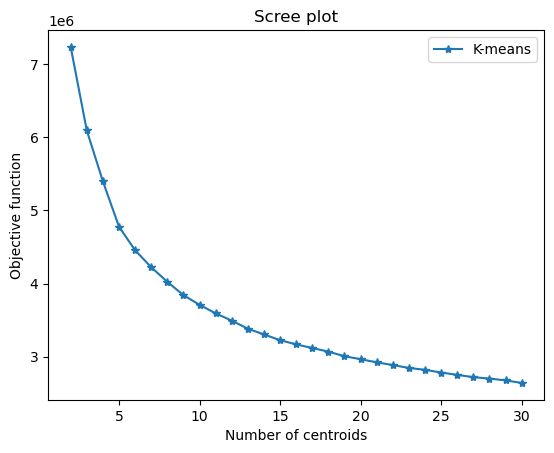

In [8]:
N_simulations=10

res_k=list()

for n_c in range(2,31):
    tmp_km = kmeans(n_c)
    min_loss = sys.maxsize
    losses = np.empty(N_simulations)
    i_tmp = 0
    iterations = np.empty(N_simulations)
    for i in range(N_simulations):
        loss,iteration,_=tmp_km.fit(data=data_pts) 
        if loss<min_loss:
            min_loss=loss
            i_min=i
            min_km = tmp_km 
        losses[i]=loss
        iterations[i]=iteration
    print(n_c,losses[i_min])    
    res_k.append([n_c,losses[i_min]])

res_k=np.array(res_k)
plt.plot(res_k[:,0], res_k[:,1], '*-', label="K-means")
plt.title("Scree plot")
plt.ylabel('Objective function')
plt.xlabel('Number of centroids')
plt.legend()

In [255]:
def tm(data,labels,k,tau):
    pi = np.zeros((k,k))
    for i in range(data.shape[0]-tau):
        a = labels[i]
        b = labels[i+tau]
        pi[a,b] += 1

    #print(pi)
    #print(np.sum(pi,axis=1,keepdims=True))

    pi = pi/np.sum(pi,axis=1,keepdims=True)

    # Check properties of a stochastic matrix
    # 1. All elements are nonzero
    # 2. sum_(alpha) Pi(alpha,beta) = 1 (for all beta)
    #assert (np.size(np.where(pi == 0)[0]) == 0)
    assert np.allclose(np.sum(pi,axis=1), 1.0, atol=1.0e-08)
    #print(pi)

    eigvals,eigvecs = np.linalg.eig(pi.T)

    sorted_index = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[sorted_index]
    sorted_eigvecs = eigvecs[:,sorted_index]

    # Make a plot for eigenvalues
    plt.plot(sorted_eigvals, 'b.')
    plt.title("Sorted Eigenvalues")
    plt.xlabel(r"l")
    plt.ylabel(r"$\tau$ number")

    statdist = eigvecs[:, np.isclose(eigvals, 1)].ravel()
    statdist /= np.sum(statdist)
    #relaxation_timescales = -tau / np.log(np.abs(eigvals[np.isclose(eigvals, 1)==False]))

    return sorted_eigvals, sorted_eigvecs, statdist

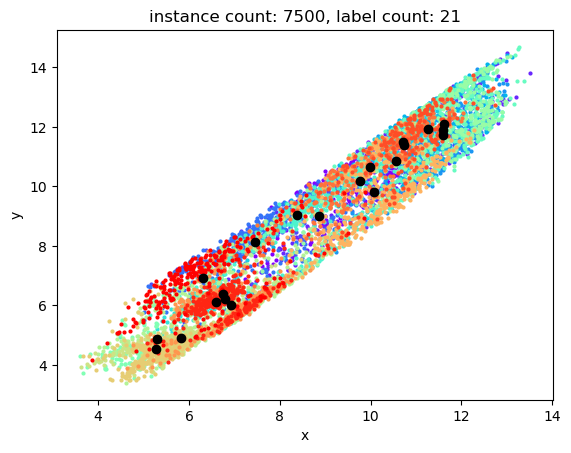

2962992.244079143 45


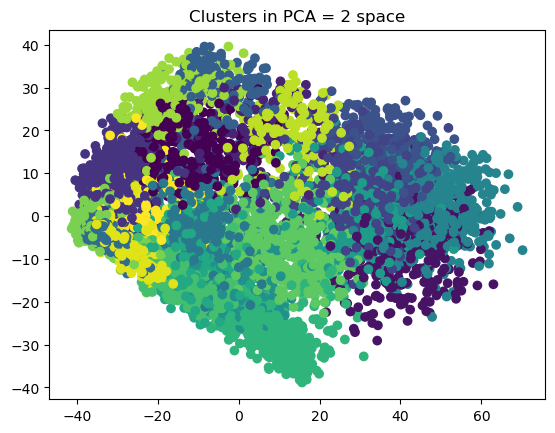

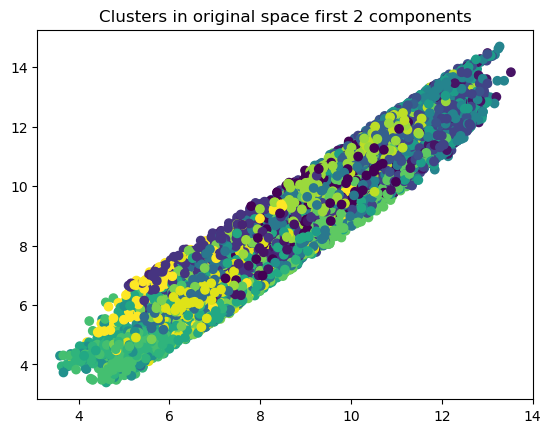

(21, 177)


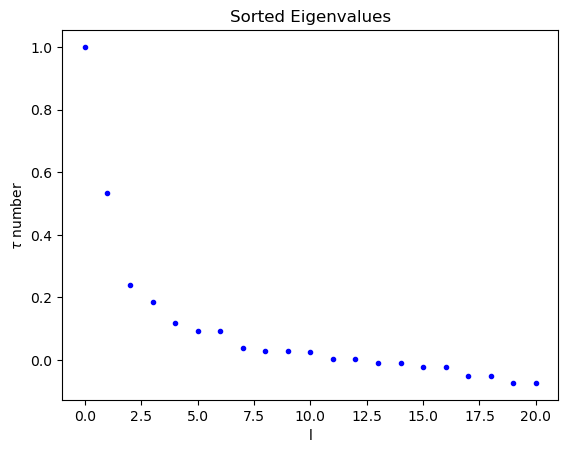

In [256]:
test_k = 21
test_km = kmeans(test_k)
loss,iteration,test_centroid_positions=test_km.fit(data)
test_km.plot()
print(loss,iteration)

test_labels = test_km.get_assignation()

plt.title(f"Clusters in PCA = {nc_pca} space")
plt.scatter(new_x[:,0], new_x[:,1], c=test_labels[:,2])
plt.show()

plt.title("Clusters in original space first 2 components")
plt.scatter(test_labels[:,0], test_labels[:,1], c=test_labels[:,2])
plt.show()

test_tau = 100
eval,evec,sd = tm(data_pts,test_labels[:,2].astype(np.int64),test_k,test_tau)

#test_centroid_positions = test_km.get_centroid_positions()
print(test_centroid_positions.shape)

[0.05191948+0.j 0.04226357+0.j 0.01853633+0.j 0.06309514+0.j
 0.05684903+0.j 0.03752346+0.j 0.02467918+0.j 0.05281814+0.j
 0.07139068+0.j 0.05556132+0.j 0.02813194+0.j 0.04069597+0.j
 0.06086558+0.j 0.07943052+0.j 0.04384064+0.j 0.0625898 +0.j
 0.0697527 +0.j 0.03277727+0.j 0.02601583+0.j 0.04560286+0.j
 0.03566055+0.j]


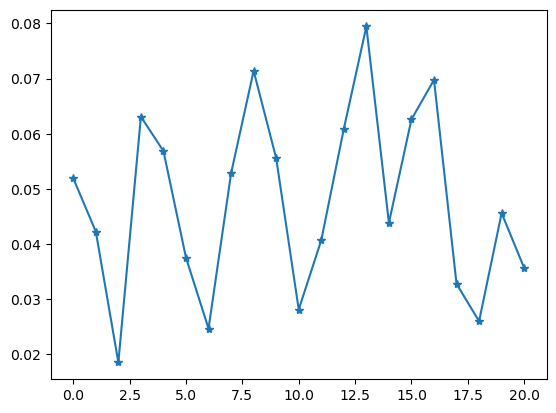

In [257]:
#print(evec)
#aaaa = evec[:, np.isclose(eval, 1)].ravel()
#print(aaaa)
#aaaa /= np.sum(aaaa)
#print(aaaa)

print(sd)

plt.plot(sd,'*-')

In [258]:
# Choose the number of Markov states based on the spectral gap
spectral_gap = eval[0] - eval[1]
num_states = np.sum(eval > spectral_gap)

print(spectral_gap)
print(num_states)

(0.46676142064056325+0j)
2


In [269]:
# Inspect the sign of the leading eigenvectors to identify the Markov states
markov_states = np.zeros(test_k)
for i in range(test_k):
    #if evec[i, 1] > 0:
    if evec[i, 0] > 0:
        markov_states[i] = 1
        #print(evec[i,0])
    else:
        markov_states[i] = -1
        #print(evec[i,0])

print(markov_states)
#print(evec)

# right eigenvectors of Pi sum to 0 except the one corresponding to eigval=1
print(evec.sum(axis=0)) 
np.isclose(evec.sum(axis=0),0.0,atol=1.0e-08)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 4.33158030e+00+0.00000000e+00j  1.80758186e-15+0.00000000e+00j
  1.11716192e-15+0.00000000e+00j -5.55111512e-16+0.00000000e+00j
 -1.91166527e-15+0.00000000e+00j -6.52256027e-16-4.07660017e-16j
 -6.52256027e-16+4.07660017e-16j -4.16333634e-16+0.00000000e+00j
  5.85252333e-16+6.73072709e-16j  5.85252333e-16-6.73072709e-16j
 -2.49800181e-16+0.00000000e+00j -1.00613962e-16+3.60822483e-16j
 -1.00613962e-16-3.60822483e-16j  7.77156117e-16+1.11022302e-16j
  7.77156117e-16-1.11022302e-16j -8.32667268e-16+2.08166817e-16j
 -8.32667268e-16-2.08166817e-16j  8.32667268e-16+1.73472348e-16j
  8.32667268e-16-1.73472348e-16j -5.55111512e-17-2.81025203e-16j
 -5.55111512e-17+2.81025203e-16j]


array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

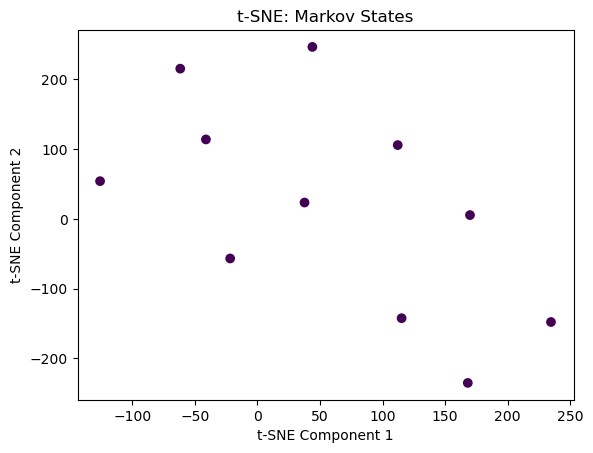

In [204]:
# 4: Dimensionality reduction and visualization
# Perform t-SNE on the microstates to obtain a 2D embedding
embedding = TSNE(n_components=2, perplexity=7, random_state=1729).fit_transform(test_centroid_positions)

# Plot the Markov states in the embedding
plt.scatter(embedding[:, 0], embedding[:, 1], c=markov_states)
plt.title('t-SNE: Markov States')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

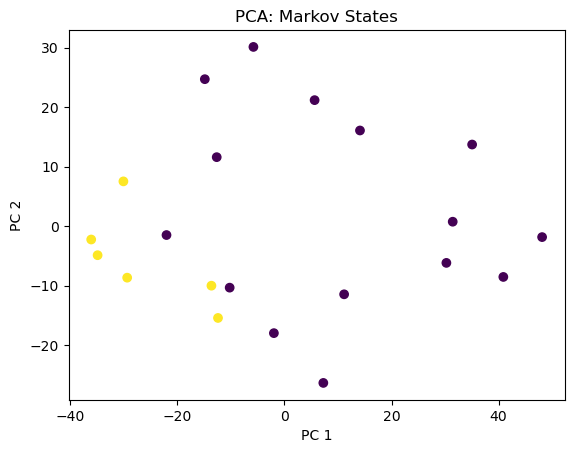

In [268]:
# 4: Dimensionality reduction and visualization
# Perform PCA on the microstates to obtain a 2D embedding

pca_vis = PCA(n_components=2)
new_centroid_positions = pca_vis.fit_transform(test_centroid_positions)

plt.scatter(new_centroid_positions[:,0], new_centroid_positions[:,1], c=markov_states)
plt.title('PCA: Markov States')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()